# Cell instance segmentation
Our network predicts two 3-d heatmaps: one predicts the cell locations and the other predicts the cell nucleus segmentations. We produce the final masks via marker-based watershed of the predicted segmentations using the centroids as markers. Network expects isotropic inputs at 1 um^3 resolution. <!--We tested it in stacks recorded from four diff microscopes: 2 two-photon, one three-photon and one mesoscope.-->

Four tunable parameters can be sent in the `prob2labels` function: seg_threshold, the threshold for the segmentation map; min_voxels, minimum number of voxels allowed for each mask; max_voxels, maximum number of voxels allowed per mask and compactness_factor, the factor used in compact watershed to bias masks into more spherical shapes (see docs for details). The main parameter is the seg_threshold: lowering it increases recall but adds false positives, increasing it produces tighter masks but loses the smaller/less confident cells. We chose 0.825 via cross-validation (average best threshold across the four models we plan to ensemble); numbers between 0.5-0.9 should be ok.

#### Other easy improvements to apply "in production"
 * Drop some pixels around the edges and reflect pad the volume (including in z, 20 pixels should be enough) to avoid edge effects.
 * Ensemble the models trained in different subsets of the data (threshold of 0.825 used below works well for all of them).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Import model from file
from bl3d import models
net = models.QCANet()
net.load_state_dict(torch.load('data/bestndn_1-9-17026.pth'))
net.eval()
net.to(device)

QCANet(
  (core): DenseNet(
    (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (layers): Sequential(
      (0): DenseBlock(
        (modules_): ModuleList(
          (0): Sequential(
            (0): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace)
            (2): Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (1): Sequential(
            (0): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace)
            (2): Conv3d(24, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (2): Sequential(
            (0): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace)
            (2): Conv3d(32, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      

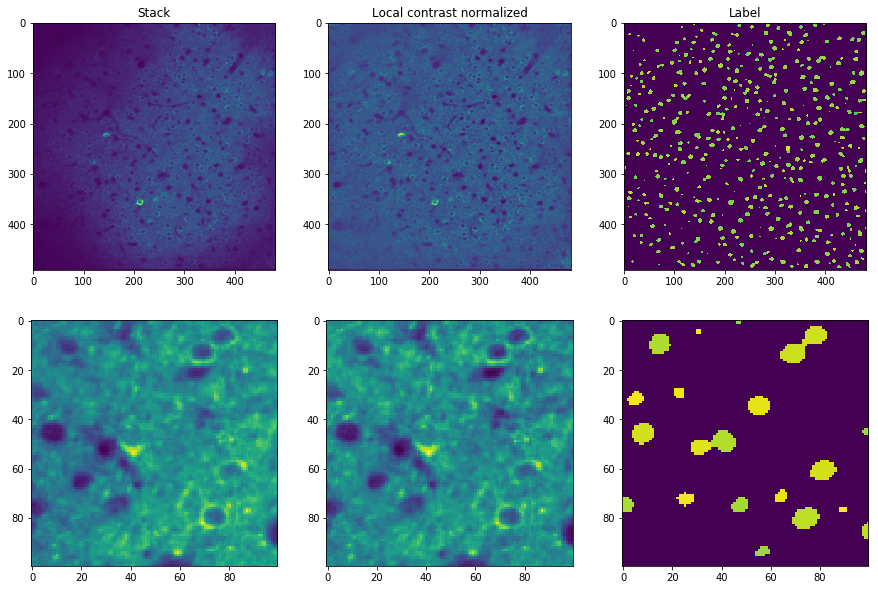

In [3]:
from bl3d import utils

# Load stack (199 x 491 x 481 mm^3); this was corrected and rescaled to 1 um^3 per voxel
stack = np.load('data/example1_17026-20-1.npy') # this example was used for validation during training
label = np.load('data/label1_17026-20-1.npy')
lcned = utils.lcn(stack, (3, 25, 25)) # preprocessing done before training

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].set_title('Stack')
axes[0, 0].imshow(stack[100])
axes[0, 1].set_title('Local contrast normalized')
axes[0, 1].imshow(lcned[100])
axes[0, 2].set_title('Label')
axes[0, 2].imshow(label[100])
axes[1, 0].imshow(stack[100, 200:300, 200:300])
axes[1, 1].imshow(lcned[100, 200:300, 200:300])
axes[1, 2].imshow(label[100, 200:300, 200:300])

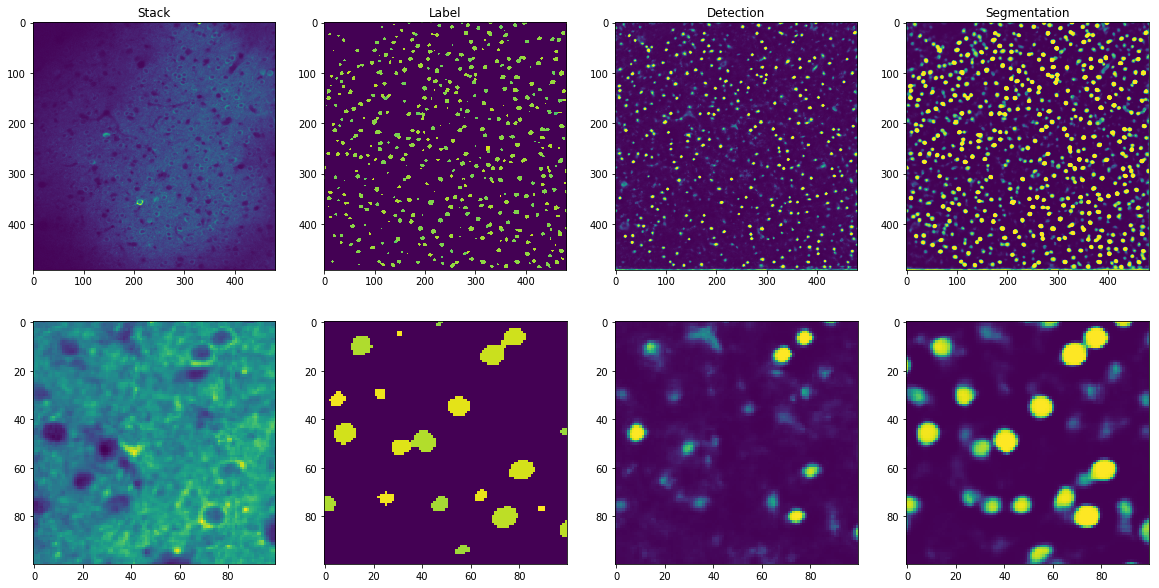

In [4]:
# Prepare input
norm = (lcned - lcned.mean()) / lcned.std()
input_ = torch.as_tensor(norm[np.newaxis, np.newaxis, ...]) # 1 x 1 x D x H x W

# Segment
with torch.no_grad():
    detection, segmentation = net.forward_on_big_input(input_)
    detection = torch.sigmoid(detection).squeeze().numpy()
    segmentation = torch.sigmoid(segmentation).squeeze().numpy()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0, 0].set_title('Stack')
axes[0, 0].imshow(stack[100])
axes[0, 1].set_title('Label')
axes[0, 1].imshow(label[100])
axes[0, 2].set_title('Detection')
axes[0, 2].imshow(detection[100])
axes[0, 3].set_title('Segmentation')
axes[0, 3].imshow(segmentation[100])
axes[1, 0].imshow(stack[100, 200:300, 200:300])
axes[1, 1].imshow(label[100, 200:300, 200:300])
axes[1, 2].imshow(detection[100, 200:300, 200:300])
axes[1, 3].imshow(segmentation[100, 200:300, 200:300])

/usr/local/lib/python3.5/dist-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


8241 initial cells
7921 final cells


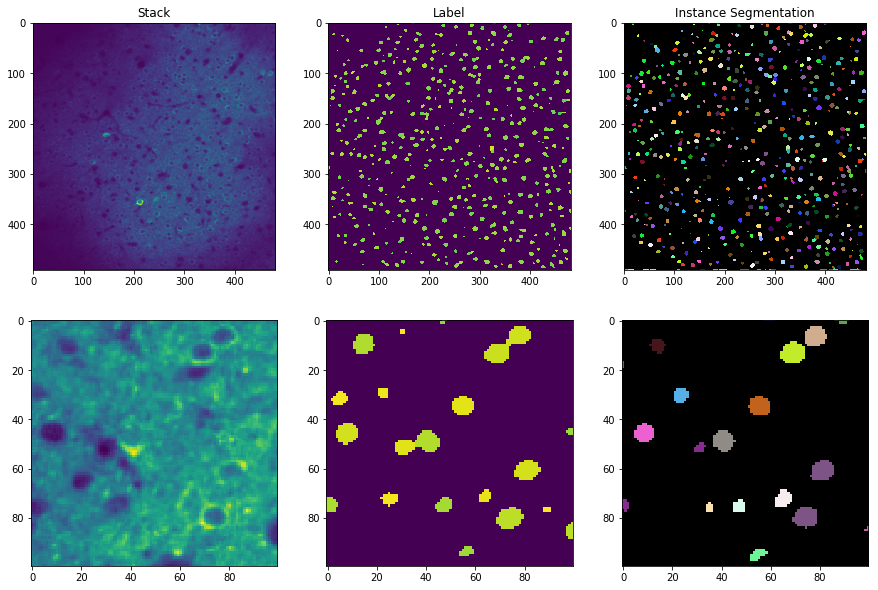

In [14]:
from bl3d import utils

# Combine segmentations
instance = utils.prob2labels(detection, segmentation, seg_threshold=0.825)
colored = utils.colorize_label(instance)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].set_title('Stack')
axes[0, 0].imshow(stack[100])
axes[0, 1].set_title('Label')
axes[0, 1].imshow(label[100])
axes[0, 2].set_title('Instance Segmentation')
axes[0, 2].imshow(colored[100])
axes[1, 0].imshow(stack[100, 200:300, 200:300])
axes[1, 1].imshow(label[100, 200:300, 200:300])
axes[1, 2].imshow(colored[100, 200:300, 200:300])

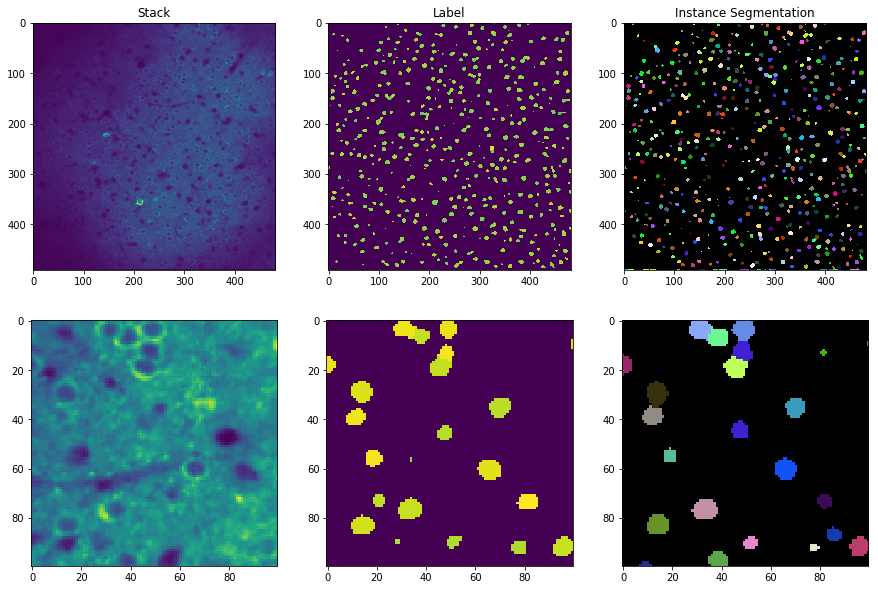

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].set_title('Stack')
axes[0, 0].imshow(stack[100])
axes[0, 1].set_title('Label')
axes[0, 1].imshow(label[100])
axes[0, 2].set_title('Instance Segmentation')
axes[0, 2].imshow(colored[100])
axes[1, 0].imshow(stack[100, 100:200, 250:350])
axes[1, 1].imshow(label[100, 100:200, 250:350])
axes[1, 2].imshow(colored[100, 100:200, 250:350])

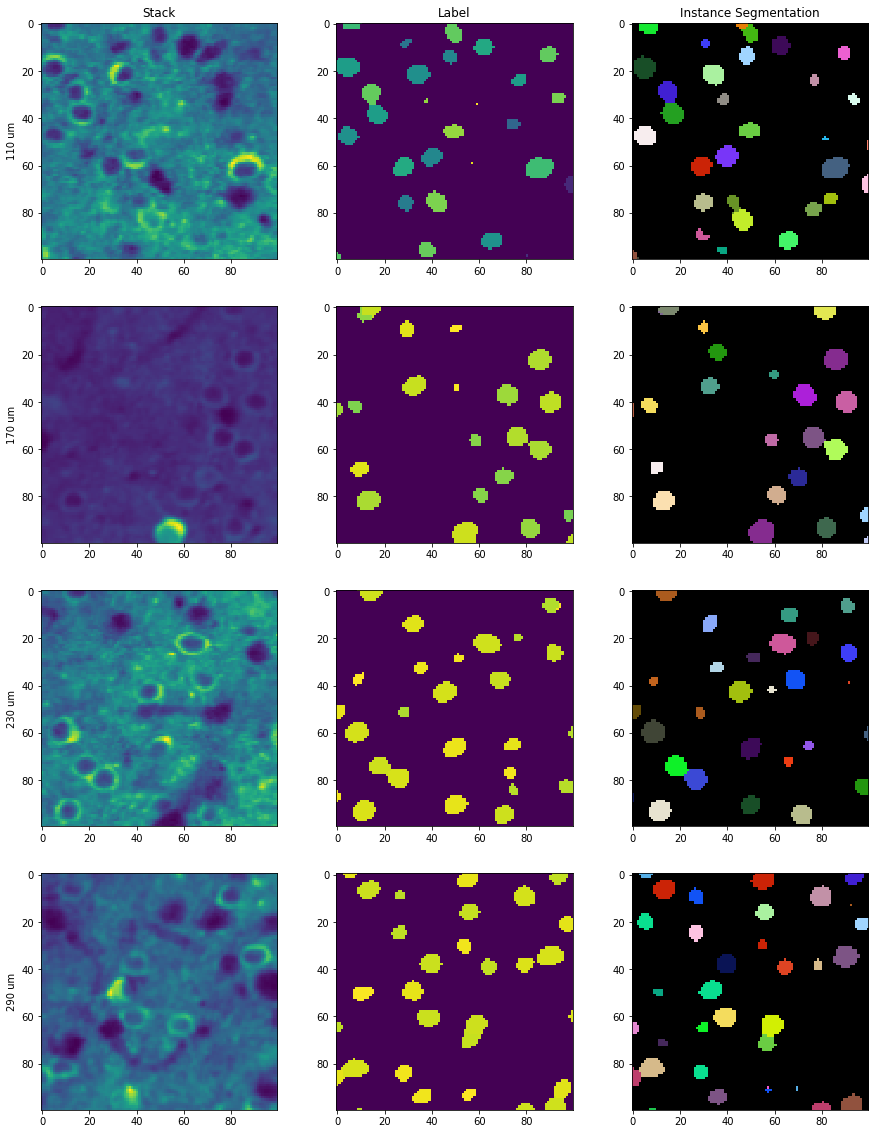

In [29]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes[0, 0].set_title('Stack')
axes[0, 0].set_ylabel('110 um')
axes[0, 0].imshow(stack[10, 100:200, 250:350])
axes[0, 1].set_title('Label')
axes[0, 1].imshow(label[10, 100:200, 250:350])
axes[0, 2].set_title('Instance Segmentation')
axes[0, 2].imshow(colored[10, 100:200, 250:350])

axes[1, 0].set_ylabel('170 um')
axes[1, 0].imshow(stack[70, 100:200, 250:350])
axes[1, 1].imshow(label[70, 100:200, 250:350])
axes[1, 2].imshow(colored[70, 100:200, 250:350])

axes[2, 0].set_ylabel('230 um')
axes[2, 0].imshow(stack[130, 100:200, 250:350])
axes[2, 1].imshow(label[130, 100:200, 250:350])
axes[2, 2].imshow(colored[130, 100:200, 250:350])

axes[3, 0].set_ylabel('290 um')
axes[3, 0].imshow(stack[-10, 100:200, 250:350])
axes[3, 1].imshow(label[-10, 100:200, 250:350])
axes[3, 2].imshow(colored[-10, 100:200, 250:350])